# Tutorial 05 - Tuning curves and decoding

## Goals

- Learn to estimate and plot 2D tuning curves
- Implement a Bayesian decoding algorithm
- Compare the decoded and actual positions by computing the decoding error

## Compute the tuning curves

In [1]:
# import necessary packages
%matplotlib inline
import os
import sys
import numpy as np
import nept
import matplotlib.pyplot as plt

# define where your data folder is located
data_path = os.path.join(os.path.abspath('.'), 'data')
data_folder = os.path.join(data_path, 'R042-2013-08-18')

In [2]:
# load the info file, which contains experiment-specific information\
sys.path.append(data_folder)
import r042d3 as info

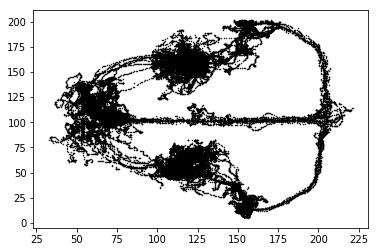

In [3]:
# Load position (.nvt) from this experiment
position = nept.load_position(os.path.join(data_folder, info.position_filename), info.pxl_to_cm)

# Plot the position
plt.plot(position.x, position.y, 'k.', ms=1)
plt.show()

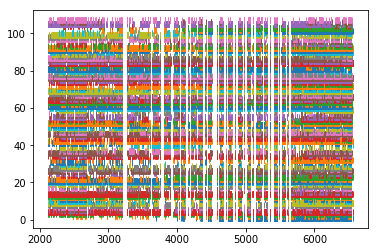

In [4]:
# Load spikes (.t and ._t) from this experiment
spikes = nept.load_spikes(data_folder)

# Plot the spikes
for idx, spiketrain in enumerate(spikes):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx, '|')
plt.show()

In [5]:
# limit position and spikes to task times
task_start = info.task_times['task'].start
task_stop = info.task_times['task'].stop

task_position = position.time_slice(task_start, task_stop)
task_spikes = [spiketrain.time_slice(task_start, task_stop) for spiketrain in spikes]

In [6]:
# limit position to those where the rat is running
run_position = task_position[nept.run_threshold(task_position, thresh=1.1, t_smooth=1.0)]

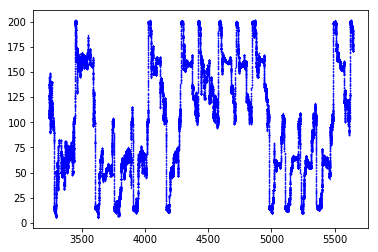

In [7]:
# Plot the running Y position over time
plt.plot(run_position.time, run_position.y, 'b.', ms=1)
plt.show()

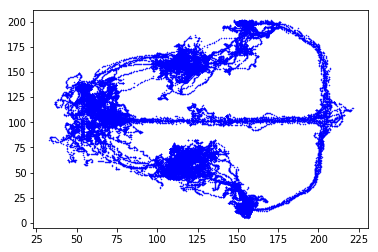

In [8]:
# Plot the running position
plt.plot(run_position.x, run_position.y, 'b.', ms=1)
plt.show()

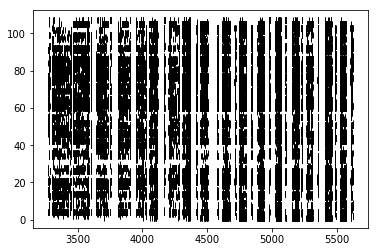

In [9]:
# Plot the task spikes
for idx, spiketrain in enumerate(task_spikes):
    plt.plot(spiketrain.time, np.ones(len(spiketrain.time))+idx, '|', color='k')
plt.show()

In [10]:
# Define the X and Y boundaries from the unfiltered position, with 3 cm bins
xedges, yedges = nept.get_xyedges(position, binsize=3)

In [11]:
tuning_curves = nept.tuning_curve_2d(run_position, np.array(task_spikes), xedges, yedges, 
                                     occupied_thresh=0.2, gaussian_std=0.1)

/home/emily/code/nept/nept/utils.py:203: UserWarning: std is too small for given dt. Signal is unchanged.
  warnings.warn("std is too small for given dt. Signal is unchanged.")


neuron: 7


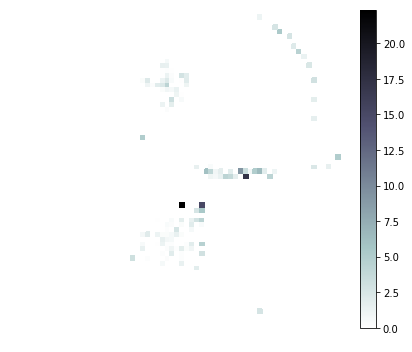

neuron: 33


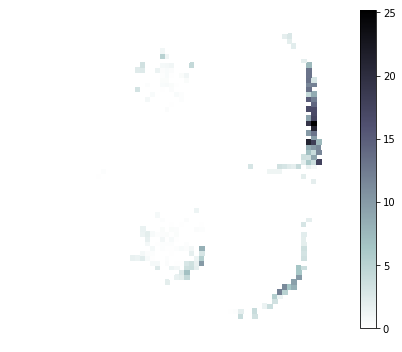

neuron: 41


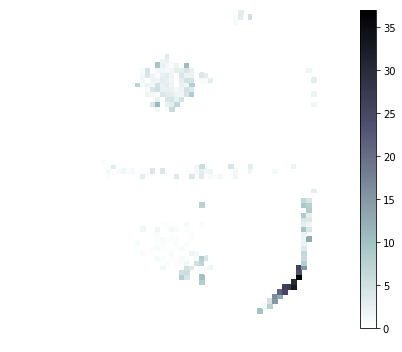

In [12]:
# Plot a few of the neuron's tuning curves
xx, yy = np.meshgrid(xedges, yedges)

for i in [7, 33, 41]:
    print('neuron:', i)
    plt.figure(figsize=(6, 5))
    pp = plt.pcolormesh(xx, yy, tuning_curves[i], cmap='bone_r')
    plt.colorbar(pp)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Decoding

Next, let's decode the location of the subject using a Bayesian algorithm.

Specifically, this is a method known as "one-step Bayesian decoding" and is
illustrated in this figure from van der Meer et al., 2010.

<img src="05-bayesian-decoding.png" width="85%" height="85%">

In [13]:
# Bin the spikes
window_size = 0.0125
window_advance = 0.0125

time_edges = nept.get_edges(run_position.time[0], run_position.time[-1], window_advance, lastbin=True)
counts = nept.bin_spikes(task_spikes, 
                         run_position.time[0], 
                         run_position.time[-1], 
                         dt=window_size, 
                         window=window_advance,
                         gaussian_std=None, 
                         normalized=True)

/home/emily/code/nept/nept/core/analogsignal.py:45: UserWarning: data should be shape (timesteps, dimensionality); got (dimensionality, timesteps). Correcting...
  warnings.warn("data should be shape (timesteps, dimensionality); "


In [14]:
# Reshape the 2D tuning curves (essentially flatten them, while keeping the 2D information intact)
tc_shape = tuning_curves.shape
decode_tuning_curves = tuning_curves.reshape(tc_shape[0], tc_shape[1] * tc_shape[2])

In [15]:
# Find the likelihoods
likelihood = nept.bayesian_prob(counts, decode_tuning_curves, window_size, min_neurons=2, min_spikes=1)

In [16]:
# Find the center of the position bins
xcenters = (xedges[1:] + xedges[:-1]) / 2.
ycenters = (yedges[1:] + yedges[:-1]) / 2.
xy_centers = nept.cartesian(xcenters, ycenters)

In [17]:
# Based on the likelihoods, find the decoded location
decoded = nept.decode_location(likelihood, xy_centers, counts.time)
nan_idx = np.logical_and(np.isnan(decoded.x), np.isnan(decoded.y))
decoded = decoded[~nan_idx]

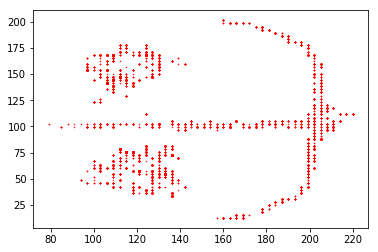

In [18]:
# Plot the decoded position
plt.plot(decoded.x, decoded.y, 'r.', ms=1)
plt.show()

## Compare the decoded to actual positions

In [19]:
# Find the actual position for every decoded time point
actual_x = np.interp(decoded.time, run_position.time, run_position.x)
actual_y = np.interp(decoded.time, run_position.time, run_position.y)
actual_position = nept.Position(np.hstack((actual_x[..., np.newaxis],
                                           actual_y[..., np.newaxis])), decoded.time)

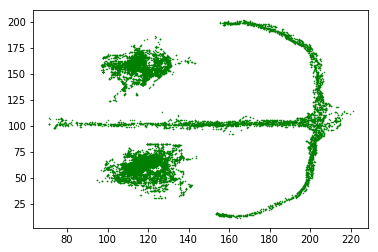

In [20]:
# Plot the actual position
plt.plot(actual_position.x, actual_position.y, 'g.', ms=1)
plt.show()

Notice the pedestal is not represented as round, as before. 
This is because we are interpolating to find an actual position 
that corresponds to each decoded time.

Mean error: 39.923373905 cm


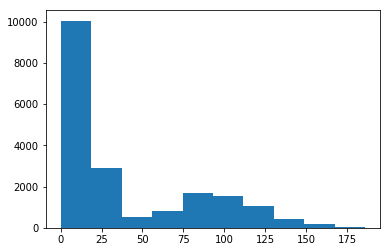

In [21]:
# Find the error between actual and decoded positions
errors = actual_position.distance(decoded)
print('Mean error:', np.mean(errors), 'cm')

# Plot the errors
plt.hist(errors)
plt.show()